# NYC Taxi Fare & Duration
## Model Training

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import wget
import pickle
import glob

sys.path.append("..")

import source.configs as configs
import preprocessing as preprocessing

# Check if we are in COLAB
IN_COLAB = 'google.colab' in sys.modules

Download dataset files (2022)

In [3]:
if IN_COLAB:
    !wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-05.parquet "../dataset"
else:
    for url in configs.START_DATASET_URLS:
        fname = url.split("/")[-1] 
        if not os.path.exists(f"../dataset/train/{fname}"):
            print(f"Downloading {fname}")
            wget.download(url, "../dataset/train")
        else:
            print(f"{fname} already in disk. Skipping download.")

yellow_tripdata_2022-05.parquet already in disk. Skipping download.


In [4]:
files_list = glob.glob("../dataset/train/*.parquet")
dataset_list = []
for file in files_list:
    print(f"Reading {file}")
    df_month = pd.read_parquet(file)
    dataset_list.append(df_month)
print("Pandas concat for dataframes...")
dataset = pd.concat(dataset_list, axis=0, ignore_index=True)
print("Done!")

Reading ../dataset/train/yellow_tripdata_2022-05.parquet
Pandas concat for dataframes...
Done!


In [6]:
print("Add targets")
dataset = preprocessing.add_targets(dataset)
print("Process outliers")
dataset = preprocessing.process_outliers(dataset, "delete")
print("Add features")

if os.path.exists("avg_speed_dict.model"):
    with open("avg_speed_dict.model", "rb") as avg_speed_dict_fd:
        avg_speed_dict = pickle.load(avg_speed_dict_fd)
else:
    print("Average speed dictionary not found!")
    
dataset, _ = preprocessing.add_features(dataset,avg_speed_dict)
print(avg_speed_dict)
print("Fill na values")
dataset = preprocessing.fill_na_values(dataset)
print("Done!")

Add targets
Process outliers
Add features
Using pre-processed average speed dictionary
{0: 0.25195469322838193, 1: 0.2503693835995309, 2: 0.24999335352944238, 3: 0.26612218282651856, 4: 0.31345897957385943, 5: 0.3355459231509819, 6: 0.27443853508122146, 7: 0.21423070424047383, 8: 0.18310836751240536, 9: 0.1801333123203435, 10: 0.17675564690190834, 11: 0.16859408041651547, 12: 0.16663810140450216, 13: 0.16766048469717576, 14: 0.16282710598596348, 15: 0.15792099847450106, 16: 0.16202178873469653, 17: 0.16106102095237498, 18: 0.16875892761499706, 19: 0.18793062365816957, 20: 0.207260086062618, 21: 0.21805265270227106, 22: 0.22578244300596678, 23: 0.24366564777182562}
Fill na values
Done!


### Features
* trip_distance
* hour_of_day: Extracted from tpep_pickup_datetime
* avg_speed: trip_distance / trip_duration. It is stored to use during inference.
* trip_d2: Trip distance squared
* rush_hour: Extracted from tpep_pickup_datetime. Binary.
### Targets
* fare_amount
* trip_duration

In [7]:
columns = preprocessing.features + preprocessing.targets
train_dataset = preprocessing.select_features(dataset, columns)
train_dataset, encoders = preprocessing.create_one_hot_encodings(train_dataset, columns)
pickle.dump(encoders, open('encoders.model', 'wb'))

In [8]:
train_dataset.columns.to_list()

['trip_distance',
 'hour_of_day',
 'rush_hour',
 'day_of_week',
 'trip_d2',
 'avg_speed',
 'fare_amount',
 'trip_duration']

In [9]:
for col in train_dataset.isna().sum():
    assert col==0
print("Ok, no NAs in train dataset!")

Ok, no NAs in train dataset!


In [10]:
train_dataset.describe()

,trip_distance,hour_of_day,rush_hour,day_of_week,trip_d2,avg_speed,fare_amount,trip_duration
count,3.289664e+06,3.289664e+06,3.289664e+06,3.289664e+06,3.289664e+06,3.289664e+06,3.289664e+06,3.289664e+06
mean,3.546120e+00,1.421627e+01,3.194651e-01,2.906948e+00,3.086053e+01,2.519547e-01,1.448234e+01,1.613262e+01
std,4.276163e+00,5.748154e+00,4.662695e-01,1.998258e+00,7.831490e+01,1.609824e-15,1.193054e+01,1.260353e+01
min,1.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-02,2.519547e-01,2.500000e+00,2.500000e-01
25%,1.170000e+00,1.100000e+01,0.000000e+00,1.000000e+00,1.368900e+00,2.519547e-01,7.000000e+00,7.733333e+00
50%,1.940000e+00,1.500000e+01,0.000000e+00,3.000000e+00,3.763600e+00,2.519547e-01,1.050000e+01,1.260000e+01
75%,3.610000e+00,1.900000e+01,1.000000e+00,5.000000e+00,1.303210e+01,2.519547e-01,1.600000e+01,2.025000e+01
max,2.500000e+01,2.300000e+01,1.000000e+00,6.000000e+00,6.250000e+02,2.519547e-01,7.500000e+01,9.000000e+01


In [11]:
train_dataset.columns.to_list()

['trip_distance',
 'hour_of_day',
 'rush_hour',
 'day_of_week',
 'trip_d2',
 'avg_speed',
 'fare_amount',
 'trip_duration']

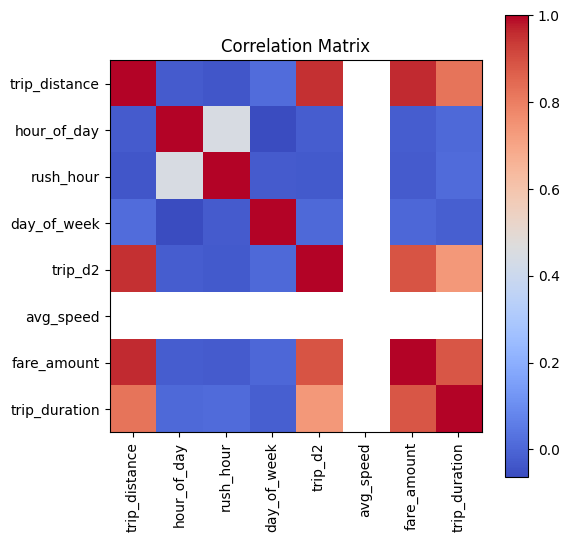

In [12]:
correlation_matrix = train_dataset.corr()
plt.figure(figsize=(6, 6))  # Adjust the figure size as needed
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()  # Add a colorbar to show the scale
plt.title('Correlation Matrix')
plt.xticks(ticks=range(len(correlation_matrix)), labels=correlation_matrix.columns, rotation=90)
plt.yticks(ticks=range(len(correlation_matrix)), labels=correlation_matrix.columns)
plt.show()

## Model Training

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

Split dataset

In [14]:
# Split features and targets
X, y = preprocessing.split_dataset(train_dataset)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_td = y_train["trip_duration"]
y_train_fa = y_train["fare_amount"]

## LINEAR MODEL

In [15]:
from sklearn.linear_model import LinearRegression
linreg_model_td = LinearRegression(n_jobs=-1)
linreg_model_fa = LinearRegression(n_jobs=-1)

In [16]:
print("Fit model TD")
linreg_model_td.fit(X_train, y_train_td.values.ravel());
print("Fit model FA")
linreg_model_fa.fit(X_train, y_train_fa.values.ravel());
print("Done!")

Fit model TD
Fit model FA
Done!


In [17]:
test_predictions_fa = linreg_model_fa.predict(X_test)
test_predictions_td = linreg_model_td.predict(X_test)

y_test_td = y_test["trip_duration"]
mse_td = mean_squared_error(y_test_td, test_predictions_td)**0.5
r2_td = r2_score(y_test_td, test_predictions_td)
print(f"Trip duration MSE: {mse_td} minutes")
print(f"Trip duration R2: {r2_td}")

y_test_fa = y_test["fare_amount"]
mse_fa = mean_squared_error(y_test_fa, test_predictions_fa)**0.5
r2_fa = r2_score(y_test_fa, test_predictions_fa)
print(f"Fare amount MSE: {mse_fa} $")
print(f"Fare amount R2: {r2_fa}")

Trip duration MSE: 6.858816849876423 minutes
Trip duration R2: 0.7035370867289176
Fare amount MSE: 3.1610901826327193 $
Fare amount R2: 0.9298126030093852


In [18]:
pickle.dump(linreg_model_fa, open('linreg_model_fa.model', 'wb'))
pickle.dump(linreg_model_td, open('linreg_model_td.model', 'wb'))

## MODEL RANDOM FOREST

In [19]:
ENABLE_RF = True

In [20]:
if ENABLE_RF:
    from sklearn.ensemble import RandomForestRegressor
    rf_model_td = RandomForestRegressor(n_jobs=-1,
                                        n_estimators=5)
    rf_model_fa = RandomForestRegressor(n_jobs=-1,
                                        n_estimators=5)

In [21]:
if ENABLE_RF:
    print("Fit model TD")
    rf_model_td.fit(X_train, y_train_td.values.ravel());
    print("Fit model FA")
    rf_model_fa.fit(X_train, y_train_fa.values.ravel());
    print("Done!")

Fit model TD


Fit model FA
Done!


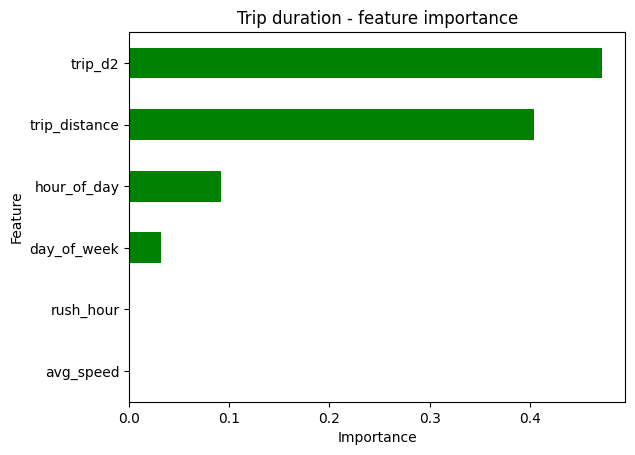

In [22]:
if ENABLE_RF:
    global_importances = pd.Series(rf_model_td.feature_importances_, index=X_train.columns)
    global_importances.sort_values(ascending=True, inplace=True)
    global_importances.plot.barh(color='green')
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Trip duration - feature importance")

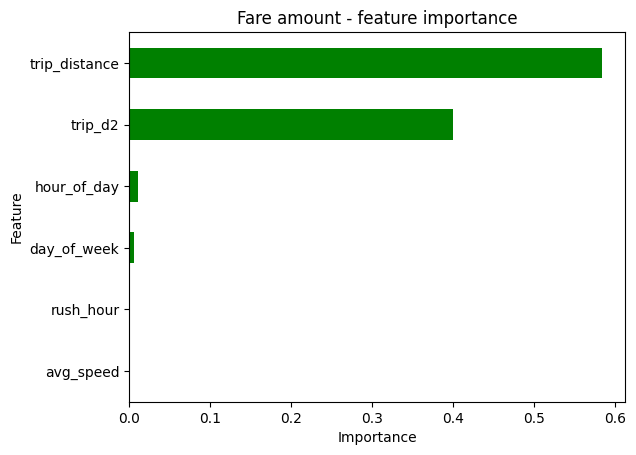

In [23]:
if ENABLE_RF:
    global_importances = pd.Series(rf_model_fa.feature_importances_, index=X_train.columns)
    global_importances.sort_values(ascending=True, inplace=True)
    global_importances.plot.barh(color='green')
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Fare amount - feature importance")

In [25]:
if ENABLE_RF:
    test_predictions_fa = rf_model_fa.predict(X_test)
    test_predictions_td = rf_model_td.predict(X_test)

    y_test_td = y_test["trip_duration"]
    mse_td = mean_squared_error(y_test_td, test_predictions_td)**0.5
    r2_td = r2_score(y_test_td, test_predictions_td)
    print(f"Trip duration MSE: {mse_td} minutes")
    print(f"Trip duration R2: {r2_td}")

    y_test_fa = y_test["fare_amount"]
    mse_fa = mean_squared_error(y_test_fa, test_predictions_fa)**0.5
    r2_fa = r2_score(y_test_fa, test_predictions_fa)
    print(f"Fare amount MSE: {mse_fa} $")
    print(f"Fare amount R2: {r2_fa}")

Trip duration MSE: 5.897887493317631 minutes
Trip duration R2: 0.7807876956393973
Fare amount MSE: 3.151460079808723 $
Fare amount R2: 0.9302395963852067


In [26]:
if ENABLE_RF:
    pickle.dump(rf_model_fa, open('rf_model_fa.model', 'wb'))
    pickle.dump(rf_model_td, open('rf_model_td.model', 'wb'))

## MODEL LIGHT GBM

In [27]:
print("Model LightGBM")
import lightgbm as lgb

train_data_lgb_td = lgb.Dataset(X_train, label=y_train_td)
train_data_lgb_fa = lgb.Dataset(X_train, label=y_train_fa)
params = {
    "objective": "regression",  # 'regression' for regression problems
    "metric": "rmse",  # Root Mean Squared Error for evaluation
    "boosting_type": "gbdt",  # Gradient Boosting Decision Tree
    "num_leaves": 10,  # Maximum number of leaves in one tree
    "learning_rate": 0.05,  # Learning rate
    "feature_fraction": 0.9,  # Fraction of features to be used in each iteration
    "bagging_fraction": 0.8,  # Fraction of data to be used for bagging
    "bagging_freq": 5,  # Frequency for bagging
    "verbose": 1,  # Verbosity (0: silent, 1: progress bar, 2: print all)
}
num_rounds = 100  # Number of boosting rounds (iterations)

Model LightGBM


In [28]:
print("Training LGBM")
print("Fit model TD")
lgbm_model_td = lgb.train(params, train_data_lgb_td, num_rounds)
print("Fit model FA")
lgbm_model_fa = lgb.train(params, train_data_lgb_fa, num_rounds)
print("Done!")

Training LGBM
Fit model TD
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 543
[LightGBM] [Info] Number of data points in the train set: 2631731, number of used features: 5
[LightGBM] [Info] Start training from score 16.137781
Fit model FA
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 543
[LightGBM] [Info] Number of data points in the train set: 2631731, number of used features: 5
[LightGBM] [Info] Start training from score 14.486215
Done!


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

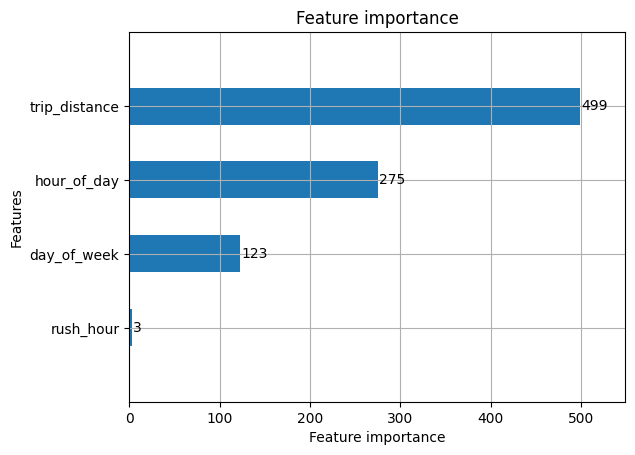

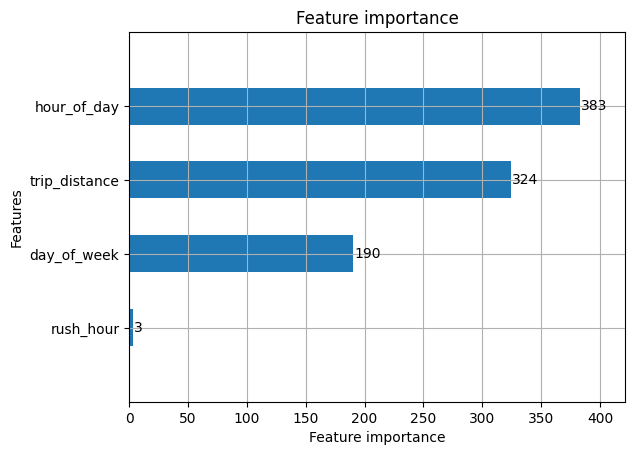

In [29]:
lgb.plot_importance(lgbm_model_fa, height=.5)
lgb.plot_importance(lgbm_model_td, height=.5)

In [31]:
test_predictions_fa = lgbm_model_fa.predict(X_test)
test_predictions_td = lgbm_model_td.predict(X_test)

y_test_td = y_test["trip_duration"]
mse_td = mean_squared_error(y_test_td, test_predictions_td)**0.5
r2_td = r2_score(y_test_td, test_predictions_td)
print(f"Trip duration RMSE: {mse_td} minutes")
print(f"Trip duration R2: {r2_td}")

y_test_fa = y_test["fare_amount"]
mse_fa = mean_squared_error(y_test_fa, test_predictions_fa)**0.5
r2_fa = r2_score(y_test_fa, test_predictions_fa)
print(f"Fare amount RMSE: {mse_fa} $")
print(f"Fare amount R2: {r2_fa}")


Trip duration RMSE: 5.507824475701621 minutes
Trip duration R2: 0.8088245403434642
Fare amount RMSE: 2.9374311832323077 $
Fare amount R2: 0.9393932820569885


In [32]:
lgbm_model_fa.save_model('lgbm_model_fa.model')
lgbm_model_td.save_model('lgbm_model_td.model')

# Inference

In [33]:
model_prefix = "lgbm"
model_name_td = f"{model_prefix}_model_td.model"
model_name_fa = f"{model_prefix}_model_fa.model"

print(model_name_td)
print(model_name_fa)

if model_prefix == "lgbm":
    import lightgbm as lgb
    model_td = lgb.Booster(model_file=model_name_td)
    model_fa = lgb.Booster(model_file=model_name_fa)
else:
    if os.path.exists(model_name_td):
        with open(model_name_td, "rb") as model_td_fd:
            model_td = pickle.load(model_td_fd)
    else:
        print("TD model not found!")

    if os.path.exists(model_name_fa):
        with open(model_name_fa, "rb") as model_fa_fd:
            model_fa = pickle.load(model_fa_fd)
    else:
        print("FA model not found!")

if os.path.exists("encoders.model"):
    with open("encoders.model", "rb") as encoders_file:
        encoders = pickle.load(encoders_file)
else:
    print("Encoders model not found!")

if os.path.exists("avg_speed_dict.model"):
    with open("avg_speed_dict.model", "rb") as avg_speed_dict_fd:
        avg_speed_dict = pickle.load(avg_speed_dict_fd)
else:
    print("Average speed dictionary not found!")

lgbm_model_td.model
lgbm_model_fa.model


Input

In [34]:
pickup_date="2024/01/03"
pickup_time="08:00:00"
tpep_pickup_datetime = pickup_date + " " + pickup_time
trip_distance = "18.0"

In [35]:
data = {
    "trip_distance": [float(trip_distance)], 
    "tpep_pickup_datetime": [pd.to_datetime(tpep_pickup_datetime)] }
df = pd.DataFrame(data)
df,_ = preprocessing.add_features(df, avg_speed_dict)
df.drop(columns="tpep_pickup_datetime", inplace=True)
print(avg_speed_dict)

Using pre-processed average speed dictionary
{0: 0.25195469322838193, 1: 0.2503693835995309, 2: 0.24999335352944238, 3: 0.26612218282651856, 4: 0.31345897957385943, 5: 0.3355459231509819, 6: 0.27443853508122146, 7: 0.21423070424047383, 8: 0.18310836751240536, 9: 0.1801333123203435, 10: 0.17675564690190834, 11: 0.16859408041651547, 12: 0.16663810140450216, 13: 0.16766048469717576, 14: 0.16282710598596348, 15: 0.15792099847450106, 16: 0.16202178873469653, 17: 0.16106102095237498, 18: 0.16875892761499706, 19: 0.18793062365816957, 20: 0.207260086062618, 21: 0.21805265270227106, 22: 0.22578244300596678, 23: 0.24366564777182562}


In [36]:
for encoder_model in encoders:
    encoder, col = encoder_model
    array = pd.DataFrame(df[col].values.reshape(1,-1), columns=[col])
    encoded_data = encoder.transform(array)
    encoded_data = encoded_data.toarray()
    encoded_df = pd.DataFrame(encoded_data, 
                            columns=encoder.get_feature_names_out([col])
    )
    df = pd.concat([df, encoded_df], axis=1, join="inner")
    df.drop(columns=col, inplace=True)

In [37]:
df.head()

,trip_distance,hour_of_day,rush_hour,day_of_week,trip_d2,avg_speed
0,18.0,8,0,2,324.0,0.183108


In [38]:
y_fa = round(model_fa.predict(df)[0],2)
y_td = int(model_td.predict(df)[0])
print(f"Trip duration: {y_td} minutes")
print(f"Fare amount: $ {y_fa}")

Trip duration: 56 minutes
Fare amount: $ 52.63
